In [1]:
#Created by: Tyler Kolisnik
#April 3, 2022

# Description:
#This code is for evaluating and finalizing a random forest model after using grid search cv to find the best parameters
#Includes scoring and validation

# Import required packages and functions
import sklearn
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from rpy2.robjects import pandas2ri
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from matplotlib import pyplot


# Increase output plot resolution
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("whitegrid")


# Import the training set data (278 samples)
pandas2ri.activate()
readRDS = robjects.r['readRDS']
ml_data=readRDS('/Volumes/FryShareNVME/2022-03-25-ML-Results-Side/2022-03-27-finalized-paper-data/microbial-plusallgenes-exploration/2022-05-29-microbial-plus-all-genes-preprocessing workflow_SIDE/output_data/2022-03-29-CPM-Microbial-PLUS-GENES-discovery-set-side-278samples.rds')
tpmdata=ml_data[0]
tpmdata2=tpmdata.transpose()
targetdata=np.ravel(ml_data[1]).astype(int)
targetlabels=np.ravel(ml_data[2])

In [2]:
# Create the classifier from the best parameter set found in the grid search CV
rforest_finalparamset = RandomForestClassifier(
    bootstrap=True,
    class_weight=None,
    criterion='gini',
    max_depth=10,
    max_features=0.025,
    max_leaf_nodes=4,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=50,
    n_jobs=2,
    oob_score=True,
    random_state=2,
    verbose=0,
    warm_start=False
)

In [3]:
# Split the dataset into training and testing
#Test Size = 0.25 instructs the model to fit on 75% of the data and test on 25%
#Stratify ensures an even distribution of samples
#Fixing random state allows for reproducibility of results
X_train, X_test, y_train, y_test = train_test_split(tpmdata2, targetdata, 
                                                    test_size=0.25,random_state=3, 
                                                    stratify=targetdata,shuffle=True)

# Fit (train) the classifier to our dataset
#alternatively import this from a file if you have already saved the model (.pkl)
rforest_finalparamset.fit(X_train,y_train)

# Load the model from disk
#filename = '/Volumes/FryShareNVME/2022-03-25-ML-Results-Side/2022-03-27-finalized-paper-data/microbial-plusallgenes-exploration/2022-04-03-genesplusbacteria-crc-side-random-forest-model.pkl'
#rforest_finalparamset = pickle.load(open(filename, 'rb'))
#rforest_finalparamset.score(X_test, Y_test)


# Make predictions from the training data
rfpredictions=rforest_finalparamset.predict(X_test)
print("Model Accuracy:",metrics.accuracy_score(y_test,rfpredictions))

Model Accuracy: 0.8


Best Threshold=0.554755, G-Mean=0.812


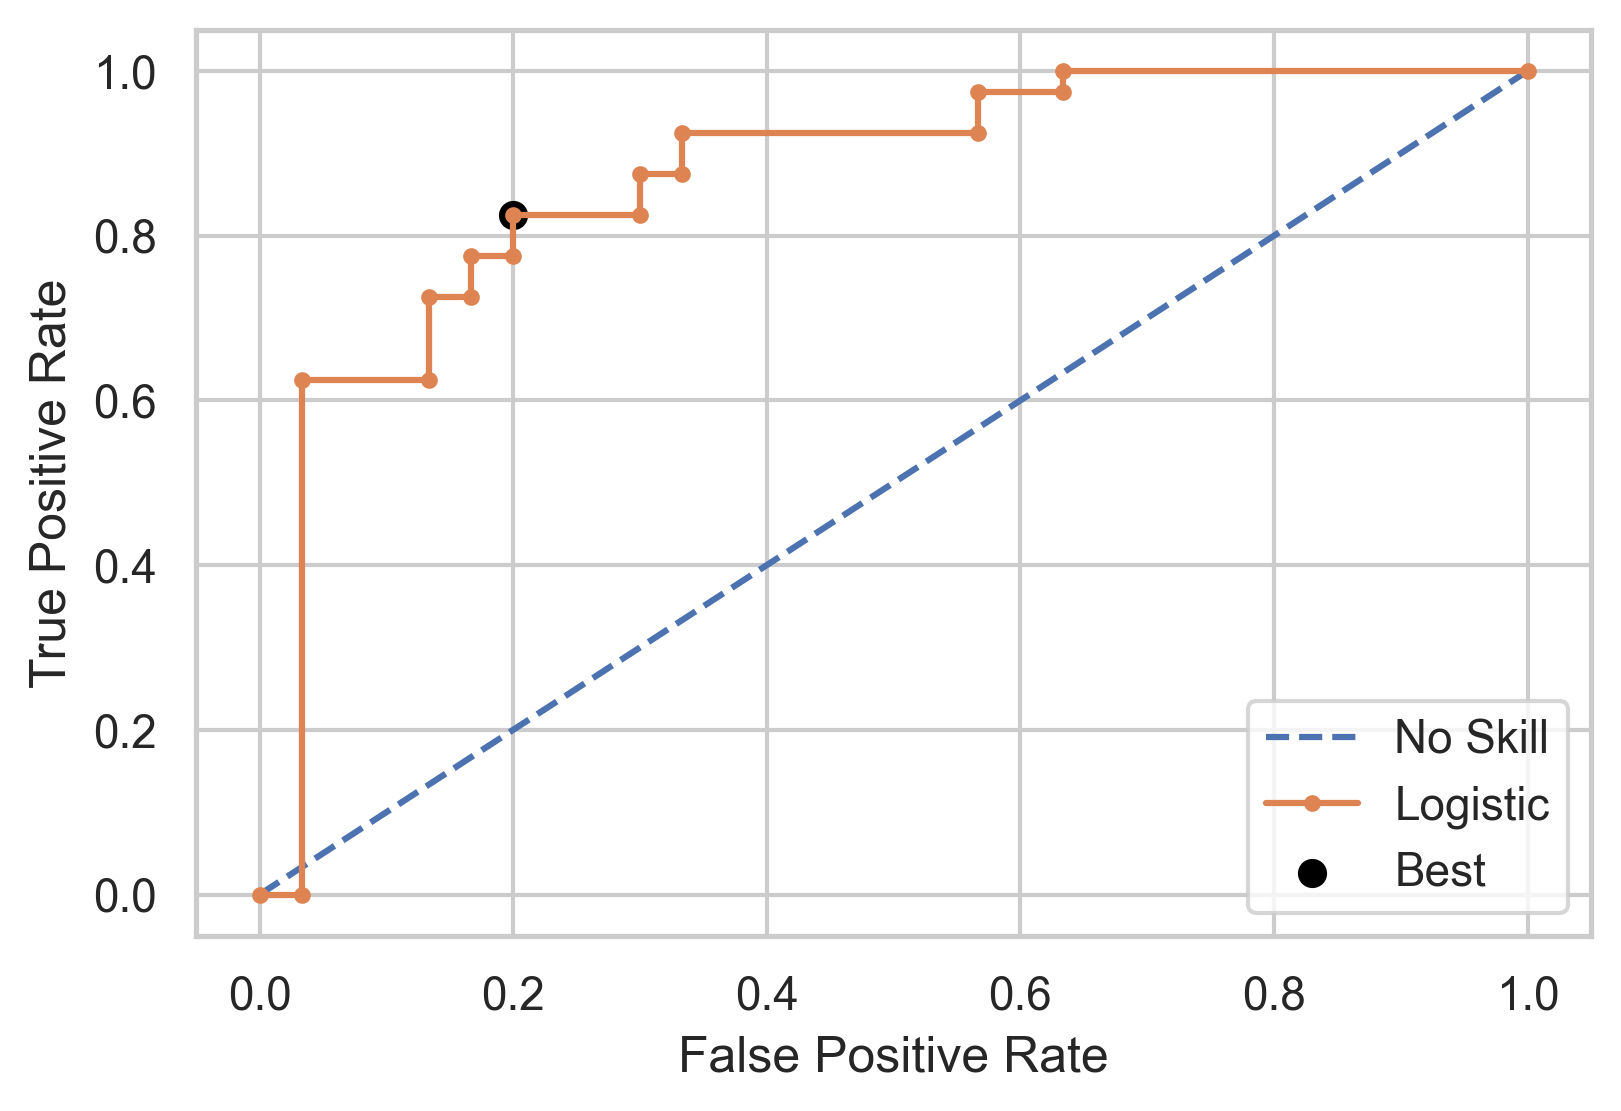

In [4]:
# Threshold hyperparameter optimization
#The default threshold for a binary variable is 0.5
#Checking the threshold allows for the optimization of the sensitivity and specificity
#and a correction for imbalanced datasets
#If a new threshold is set then you must nolonger use .predict, and must use .predict_proba



# Generate prediction probabilities (necessary for AUROC/AUPRC and thresholds)
yhat = rforest_finalparamset.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

#With Code Adapted From: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [5]:
# See how a threshold adjustment affects the training set
#I ultimately chose to just keep the 0.5 threshold as the scores are close enough
#and it is not of utmost importance in this model to prioritize 
#precision(specificity) or recall(sensitivity) over the other

threshold = 0.554755
thresholdpredictions = rforest_finalparamset.predict_proba(X_test)
discpreds2 = thresholdpredictions[:, 1]
test_predictions=rforest_finalparamset.predict(X_test)

preds = [1 if thresholdpredictions[i][1]> threshold else 0 for i in range(len(thresholdpredictions))]

print("0.554755 Threshold:")
pd.DataFrame(classification_report(y_test,preds,output_dict=True)).T

0.554755 Threshold:


,precision,recall,f1-score,support
0,0.774194,0.800000,0.786885,30.000000
1,0.846154,0.825000,0.835443,40.000000
accuracy,0.814286,0.814286,0.814286,0.814286
macro avg,0.810174,0.812500,0.811164,70.000000
weighted avg,0.815314,0.814286,0.814633,70.000000


In [6]:
print("0.5 Threshold:")
pd.DataFrame(classification_report(y_test,test_predictions,output_dict=True)).T

0.5 Threshold:


,precision,recall,f1-score,support
0,0.863636,0.633333,0.730769,30.0
1,0.770833,0.925000,0.840909,40.0
accuracy,0.800000,0.800000,0.800000,0.8
macro avg,0.817235,0.779167,0.785839,70.0
weighted avg,0.810606,0.800000,0.793706,70.0


In [7]:
# Print Scoring Metrics for Training (Model Discovery) Set 
print("Accuracy:",metrics.accuracy_score(y_test,rfpredictions))
print("Out-of-Bag Score:",rforest_finalparamset.oob_score_)
print("F1 Score:",metrics.f1_score(y_test,rfpredictions))
print("ROC AUC Score:",metrics.roc_auc_score(y_test,rfpredictions))
print("Recall Score:",metrics.recall_score(y_test,rfpredictions))
print("Precision Score:",metrics.precision_score(y_test,rfpredictions))
confmat = confusion_matrix(y_test,rfpredictions)
fp = confmat[0][1]
tn = confmat[0][0]
tp = confmat[1][1]
fn = confmat[1][0]
tprate=tp/(tp+fn)
fprate=fp/(fp+tn)

print("False Positives:",fp)
print("False Negatives:",fn)
print("True Positives:",tp)
print("True Negatives:",tn)
print("True Positive Rate:",tprate)
print("True Negative Rate:",fprate)

print(classification_report(y_test,rfpredictions))

Accuracy: 0.8
Out-of-Bag Score: 0.7355769230769231
F1 Score: 0.840909090909091
ROC AUC Score: 0.7791666666666667
Recall Score: 0.925
Precision Score: 0.7708333333333334
False Positives: 11
False Negatives: 3
True Positives: 37
True Negatives: 19
True Positive Rate: 0.925
True Negative Rate: 0.36666666666666664
              precision    recall  f1-score   support

           0       0.86      0.63      0.73        30
           1       0.77      0.93      0.84        40

    accuracy                           0.80        70
   macro avg       0.82      0.78      0.79        70
weighted avg       0.81      0.80      0.79        70



In [32]:
# Generate AUROC/AUPRC scores and create functions for plotting curves
val_auprc = sklearn.metrics.average_precision_score(y_test,rfpredictions,pos_label=1)

val_auroc = sklearn.metrics.roc_auc_score(y_test,rfpredictions)
aurocscore="AUROC="+str(round(val_auroc,2))
auprcscore="AUPRC="+str(round(val_auprc,2))
print(auprcscore)
print(aurocscore)
def plot_auroc_curve(y_test,rfpredictions,aurocscore):
    data_fpr, data_tpr, data_thresholds = sklearn.metrics.roc_curve(y_test,rfpredictions)
    data_fpr_tpr = pd.DataFrame({'fpr':data_fpr, 'tpr':data_tpr})
    p = sns.lineplot(data=data_fpr_tpr, x='fpr', y='tpr',ci=None)
    p.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    p.plot([0, 1], [0, 1], color='black', ls='--')
    p.text(0.2,0.5,aurocscore)
    
def plot_auprc_curve(y_test,rfpredictions,auprcscore):
    data_prcsn, data_rcll, data_thrshlds = sklearn.metrics.precision_recall_curve(y_test,rfpredictions)
    data_prcsn_rcll = pd.DataFrame({'prcsn':data_prcsn, 'rcll':data_rcll})
    p = sns.lineplot(data=data_prcsn_rcll, x='rcll', y='prcsn',ci=None)
    p.set(xlabel='Recall', ylabel='Precision')
    p.plot([0, 1], [1, 0], color='black', ls='--')
    p.text(0.2,0.5,auprcscore)

AUPRC=0.76
AUROC=0.78


<function __main__.plot_auroc_curve(y_test, rfpredictions, aurocscore)>

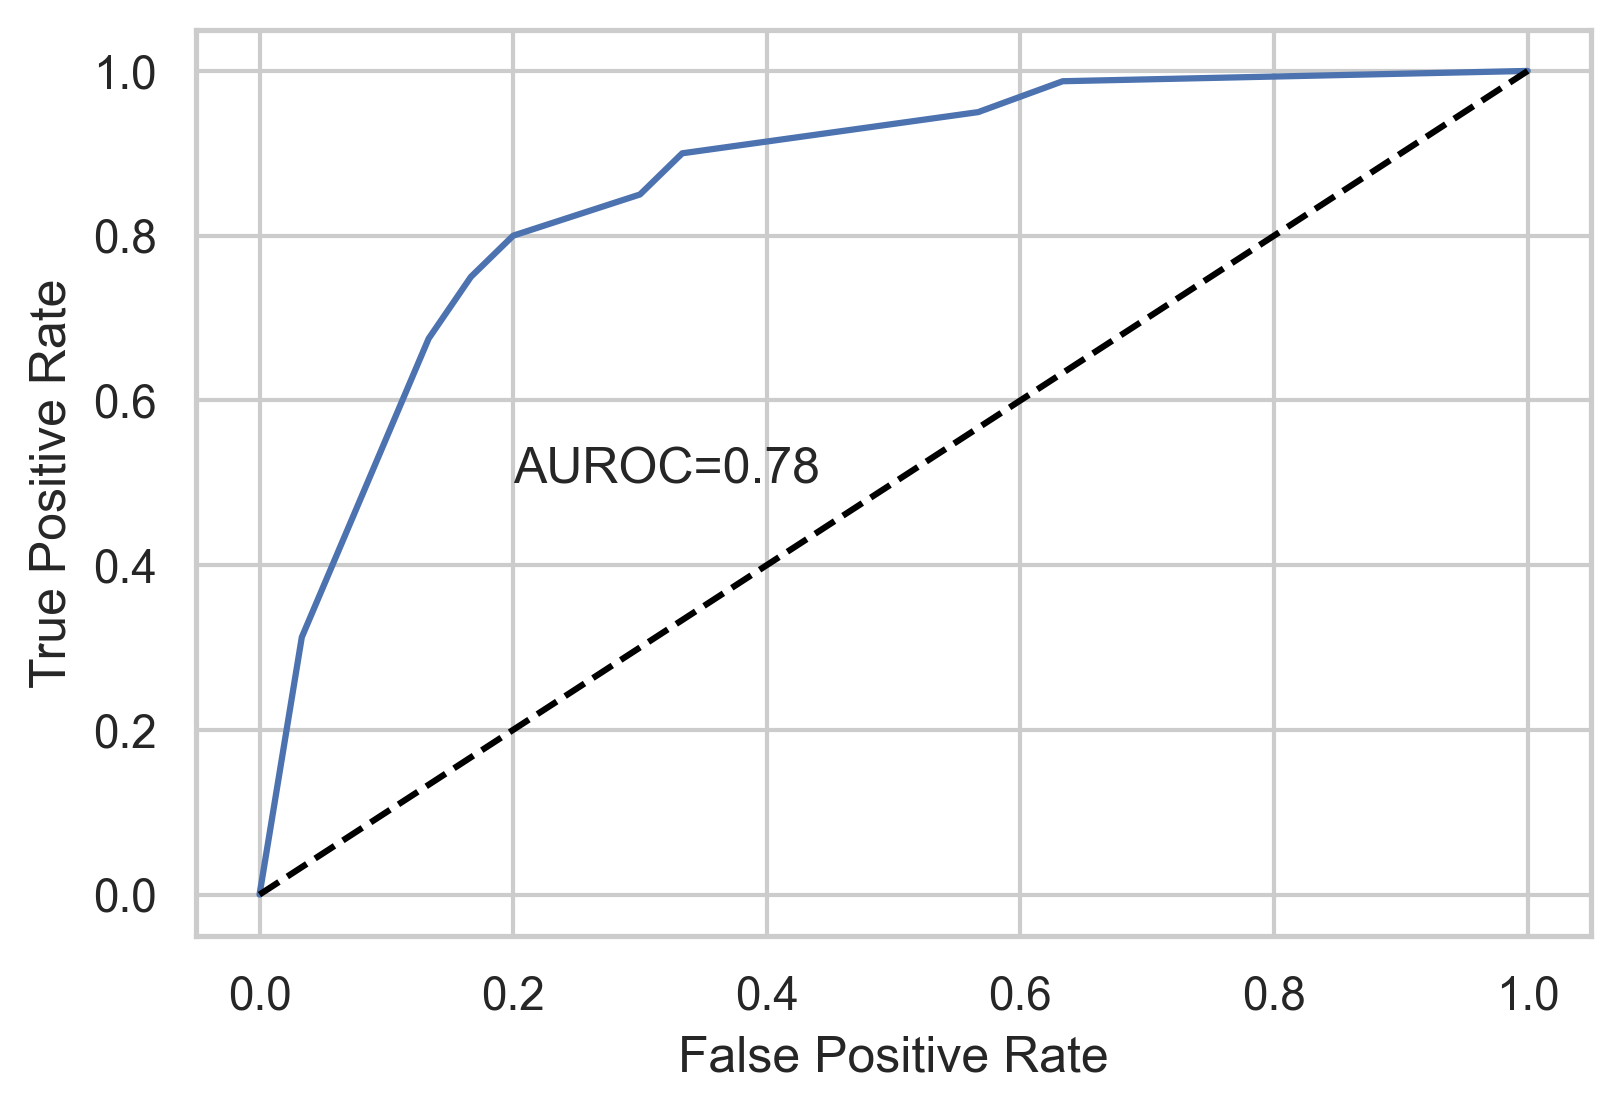

In [31]:
# Plot AUROC Curve
plot_auroc_curve(y_test,discpreds2,aurocscore)
plot_auroc_curve
# Save to file
#plt.savefig("/Volumes/FryShareNVME/2022-03-25-ML-Results-Side/2022-03-27-finalized-paper-data/microbial-plusallgenes-exploration/bacteriaplusgenes-v2-AUROC-training-set.pdf")

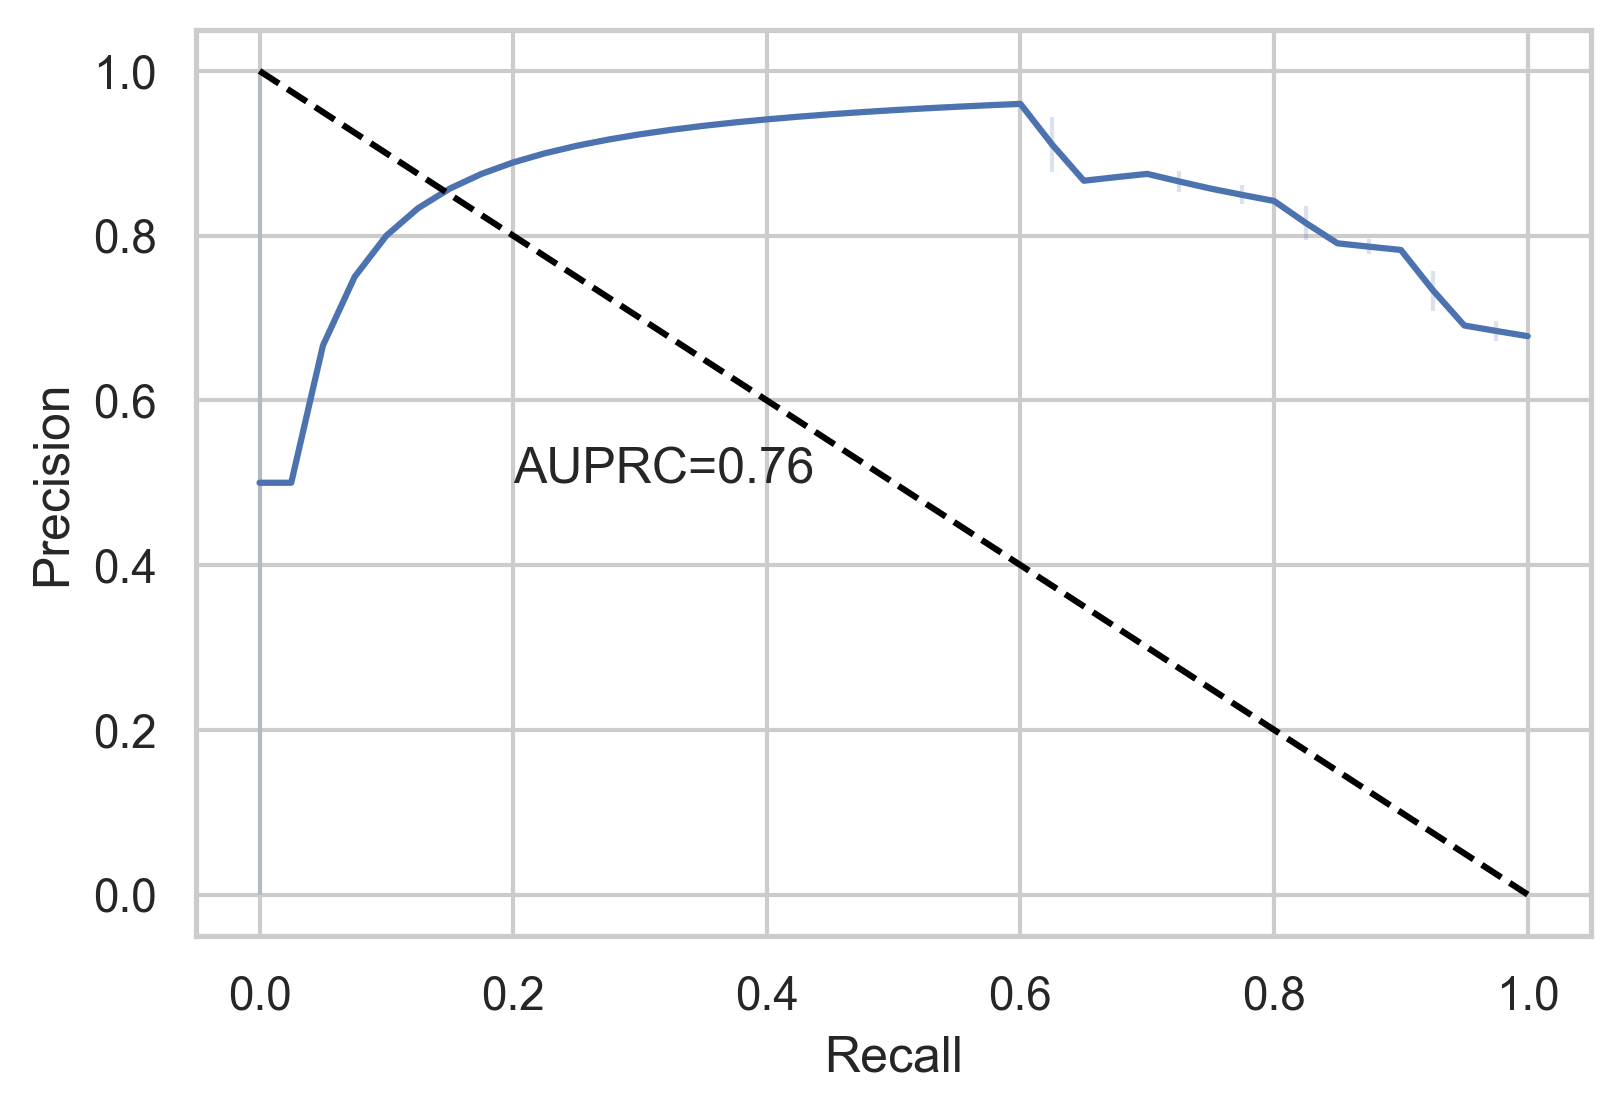

In [30]:
# Plot AUPRC Curve
plot_auprc_curve(y_test,discpreds2,auprcscore)

# Save to file
plt.savefig("/Volumes/FryShareNVME/2022-03-25-ML-Results-Side/2022-03-27-finalized-paper-data/microbial-plusallgenes-exploration/bacteriaplusgenes-v2-AUPRC-training-set.pdf")

In [11]:
# Import independent validation set (30 samples the model has never seen before)
pandas2ri.activate()
readRDS = robjects.r['readRDS']
val_data=readRDS('/Volumes/FryShareNVME/2022-03-25-ML-Results-Side/2022-03-27-finalized-paper-data/microbial-plusallgenes-exploration/2022-05-29-microbial-plus-all-genes-preprocessing workflow_SIDE/output_data/2022-03-29-CPM-Microbial-PLUS-GENES-validation-set-side-30samples.rds')
valdata=val_data[0]
valdata2=valdata.transpose()
valtargetdata=np.ravel(val_data[1]).astype(int)

In [12]:
# Run the model on the validation set
runmodelonvaldata=rforest_finalparamset.predict(valdata2)

In [13]:
# Generate prediction probabilities (necessary for AUROC/AUPRC and thresholds)
val_prob_preds = rforest_finalparamset.predict_proba(valdata2)

# Take only the positive values
val_preds = val_prob_preds[:, 1]

In [14]:
# Print Scoring Metrics for Validation Set
print("Accuracy:",metrics.accuracy_score(runmodelonvaldata, valtargetdata))
print("F1 Score:",metrics.f1_score(runmodelonvaldata, valtargetdata))
print("ROC AUC Score:",metrics.roc_auc_score(runmodelonvaldata, valtargetdata))
print("Recall Score:",metrics.recall_score(runmodelonvaldata, valtargetdata))
print("Precision Score:",metrics.precision_score(runmodelonvaldata, valtargetdata))
confmat = confusion_matrix(runmodelonvaldata,valtargetdata)
fp = confmat[0][1]
tn = confmat[0][0]
tp = confmat[1][1]
fn = confmat[1][0]
tprate=tp/(tp+fn)
fprate=fp/(fp+tn)

print("False Positives:",fp)
print("False Negatives:",fn)
print("True Positives:",tp)
print("True Negatives:",tn)
print("True Positive Rate:",tprate)
print("True Negative Rate:",fprate)

print(classification_report(runmodelonvaldata, valtargetdata))

Accuracy: 0.8666666666666667
F1 Score: 0.8823529411764706
ROC AUC Score: 0.8947368421052632
Recall Score: 0.7894736842105263
Precision Score: 1.0
False Positives: 0
False Negatives: 4
True Positives: 15
True Negatives: 11
True Positive Rate: 0.7894736842105263
True Negative Rate: 0.0
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       1.00      0.79      0.88        19

    accuracy                           0.87        30
   macro avg       0.87      0.89      0.86        30
weighted avg       0.90      0.87      0.87        30



In [15]:
# Generate validation set AUROC/AUPRC scores
val_auprc = sklearn.metrics.average_precision_score(runmodelonvaldata, valtargetdata,pos_label=1)

val_auroc = sklearn.metrics.roc_auc_score(runmodelonvaldata, valtargetdata)
aurocscore="AUROC="+str(round(val_auroc,2))
auprcscore="AUPRC="+str(round(val_auprc,2))
print(auprcscore)
print(aurocscore)

AUPRC=0.92
AUROC=0.89


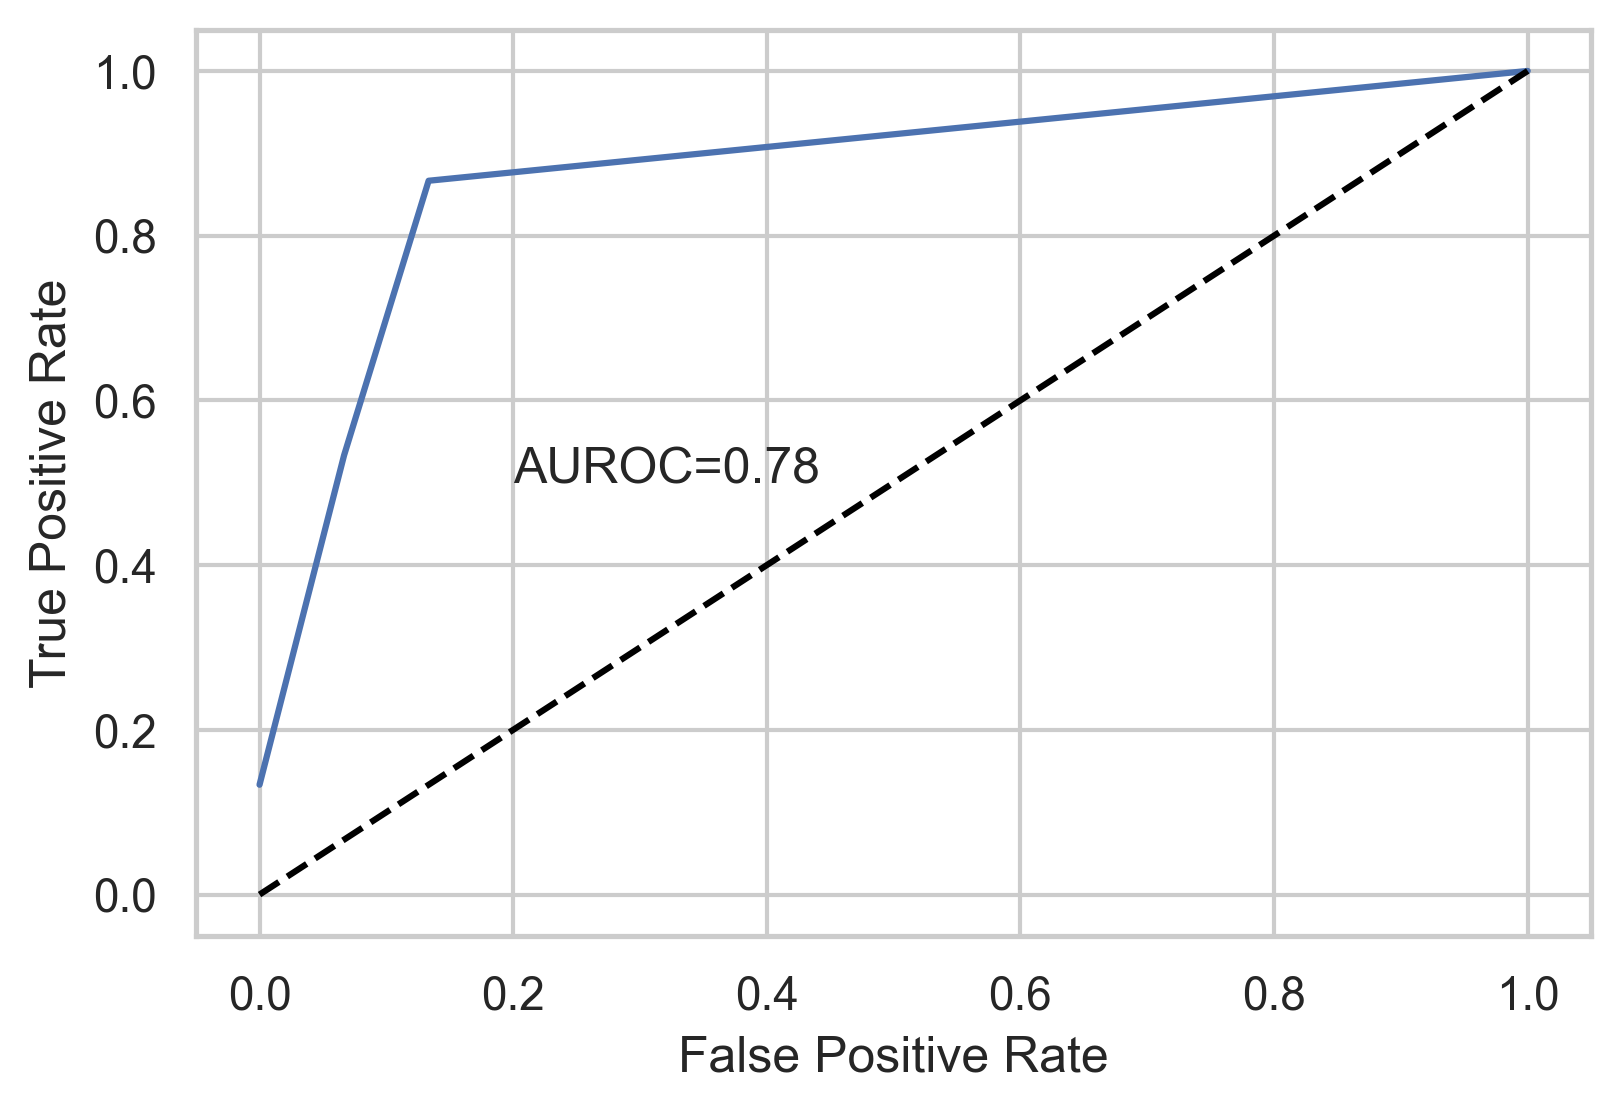

In [34]:
# Plot AUROC Curve
auroccurve=plot_auroc_curve(valtargetdata,val_preds,aurocscore)
auroccurve
# Save to file
plt.savefig("/Volumes/FryShareNVME/2022-03-25-ML-Results-Side/2022-03-27-finalized-paper-data/microbial-plusallgenes-exploration/bacteriaplusgenes-v2-AUROC-validation-set.pdf")

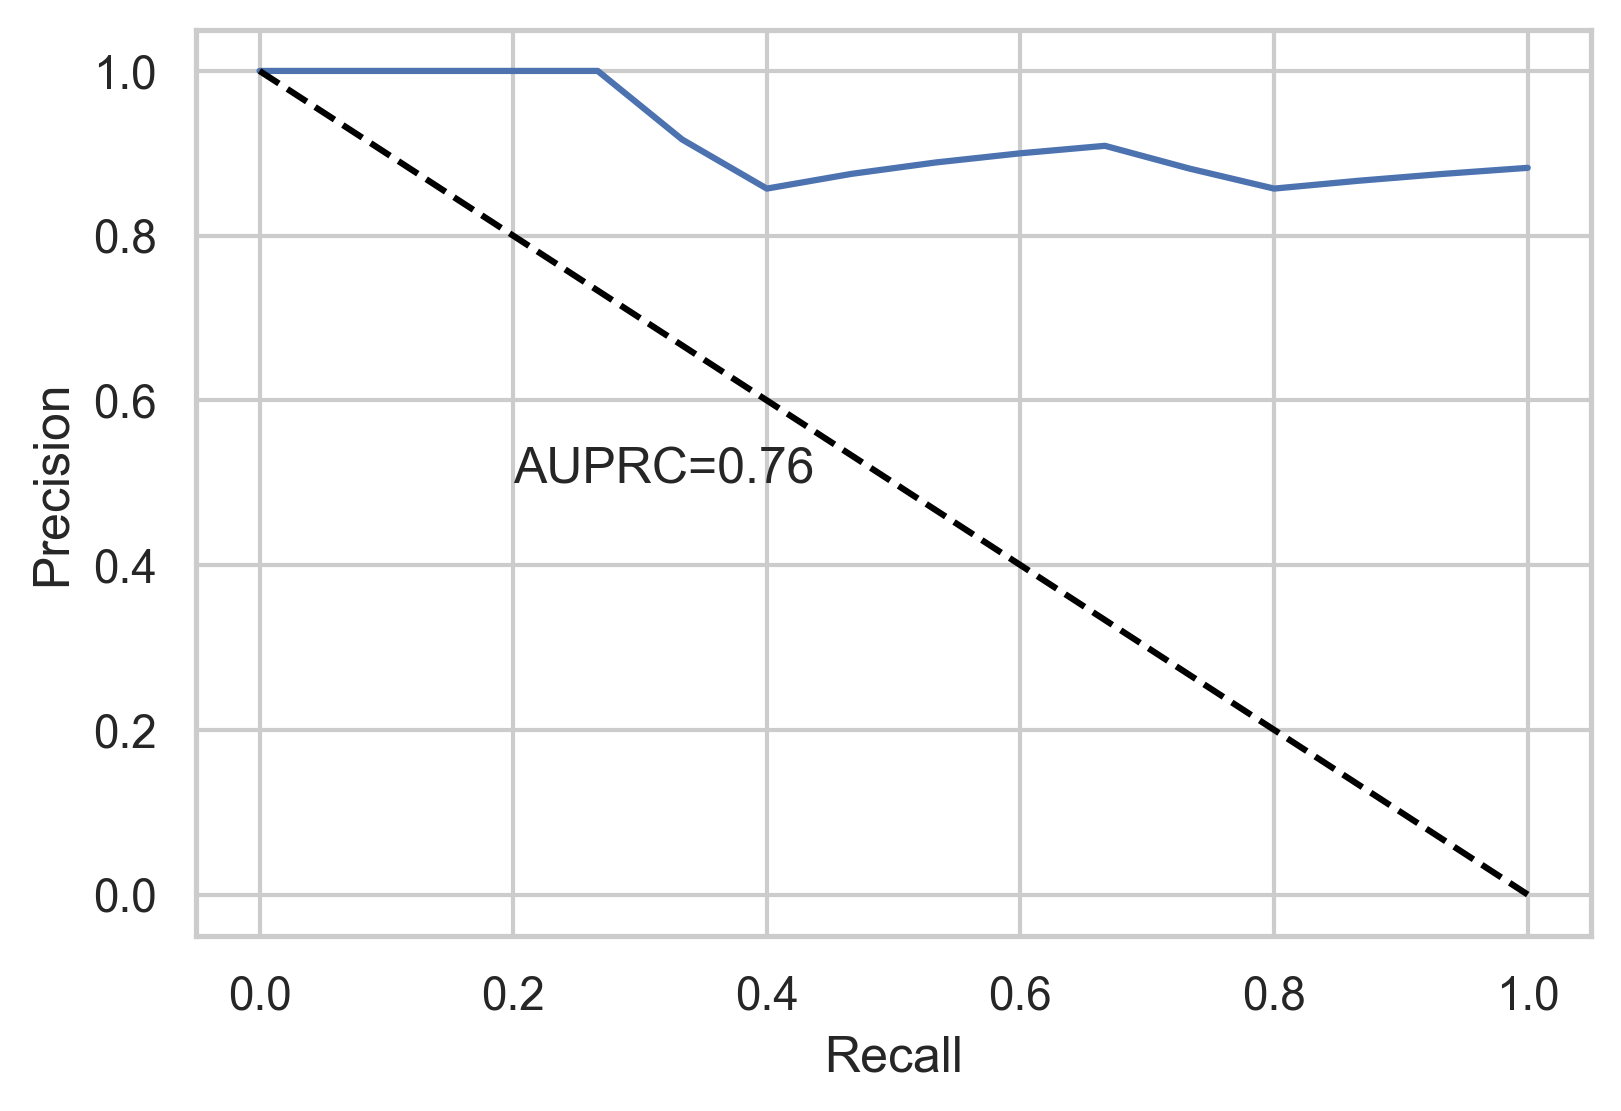

In [35]:
# Plot AUPRC Curve
plot_auprc_curve(valtargetdata,val_preds,auprcscore)

# Save to file
plt.savefig("/Volumes/FryShareNVME/2022-03-25-ML-Results-Side/2022-03-27-finalized-paper-data/microbial-plusallgenes-exploration/bacteriaplusgenes-v2-AUPRC-validation-set.pdf")

In [25]:
# See how a threshold adjustment affects the validation set (as a post-measure of performance, not for threshold optimization)
#I ultimately chose to just keep the 0.5 threshold as the scores are close enough
#and it is not of utmost importance in this model to prioritize 
#precision(specificity) or recall(sensitivity) over the other

threshold = 0.554755 # define threshold here
thresholdpredictions = rforest_finalparamset.predict_proba(valdata2)
valpredictions=rforest_finalparamset.predict(valdata2)

preds = [1 if thresholdpredictions[i][1]> threshold else 0 for i in range(len(thresholdpredictions))]

# Print Classification Report for New Threshold
print("0.570738 Threshold:")
pd.DataFrame(classification_report(valtargetdata,preds,output_dict=True)).T

0.570738 Threshold:


,precision,recall,f1-score,support
0,0.866667,0.866667,0.866667,15.000000
1,0.866667,0.866667,0.866667,15.000000
accuracy,0.866667,0.866667,0.866667,0.866667
macro avg,0.866667,0.866667,0.866667,30.000000
weighted avg,0.866667,0.866667,0.866667,30.000000


In [26]:
# Print Classification Report for 0.5 Threshold (Default)
print("0.5 Threshold:")
pd.DataFrame(classification_report(valtargetdata,valpredictions,output_dict=True)).T

0.5 Threshold:


,precision,recall,f1-score,support
0,1.000000,0.733333,0.846154,15.000000
1,0.789474,1.000000,0.882353,15.000000
accuracy,0.866667,0.866667,0.866667,0.866667
macro avg,0.894737,0.866667,0.864253,30.000000
weighted avg,0.894737,0.866667,0.864253,30.000000


In [27]:
# Save the feature importance scores of the random forest model mapped to the features (genes)
ftnames=rforest_finalparamset.feature_names_in_
ftimportances=rforest_finalparamset.feature_importances_
df=pd.DataFrame({ 'feature_names':ftnames,'feature_importances':ftimportances,})
#df.shape
# Save to file
df.to_csv("/Volumes/FryShareNVME/2022-03-25-ML-Results-Side/2022-03-27-finalized-paper-data/microbial-plusallgenes-exploration/2022-04-05-bacteriaplusgenes-v2-crc-rf-final-feature-importance-scores.csv")

In [29]:
# Save the model to disk
filename = '/Volumes/FryShareNVME/2022-03-25-ML-Results-Side/2022-03-27-finalized-paper-data/microbial-plusallgenes-exploration/2022-04-03-microbialplusallgenes-v2-crc-side-random-forest-model.pkl'
pickle.dump(rforest_finalparamset, open(filename, 'wb'))
 